In [29]:
import os.path
import time
import pylab as pl
import numpy as np
from scipy import rand
from scipy.io import loadmat
%pylab inline
import os
import time
from scipy.io import savemat, loadmat
import copy
import pandas as pd
from scipy.io import loadmat
import seaborn as sns
import scipy
import math
def truncate(number, digits) -> float:
    stepper = 10.0 ** digits
    return math.trunc(stepper * number) / stepper
sns.set()

Populating the interactive namespace from numpy and matplotlib


/Users/gracemclaughlin/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


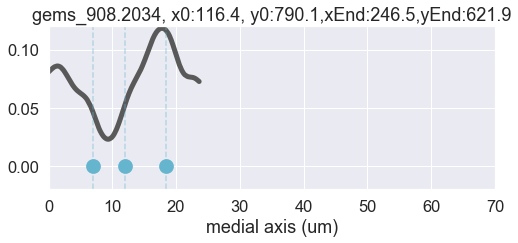

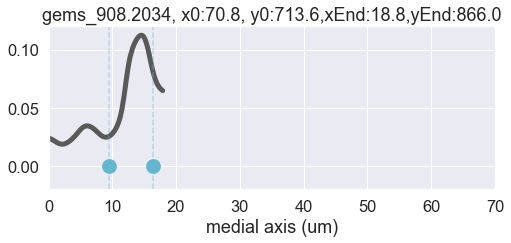

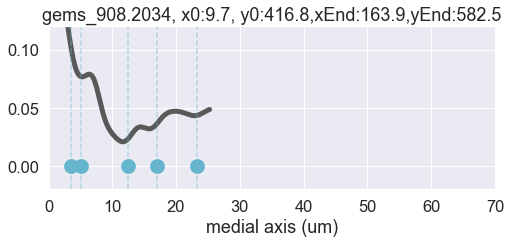

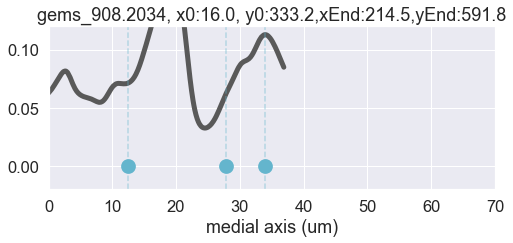

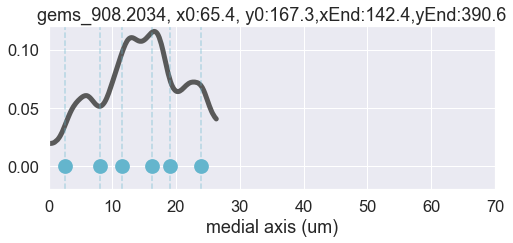

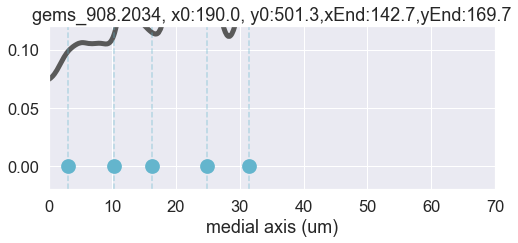

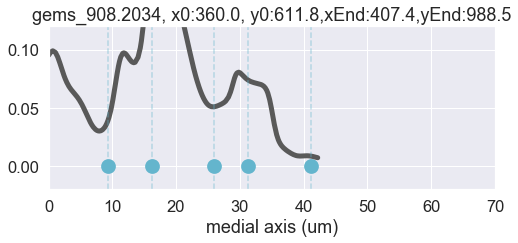

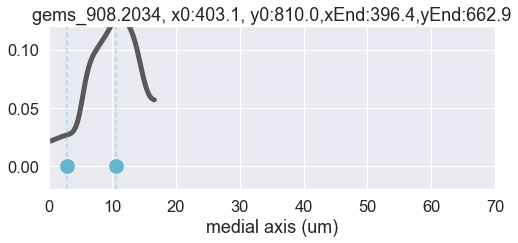

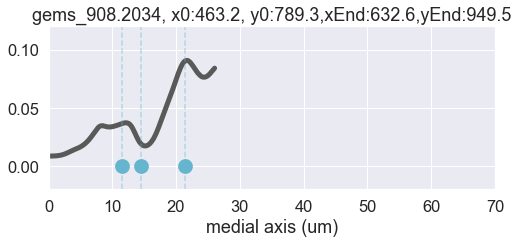

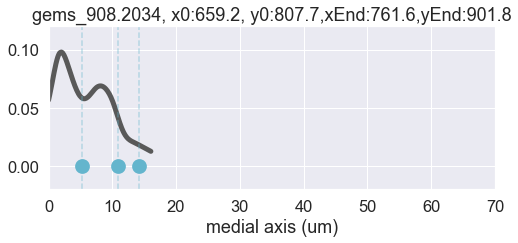

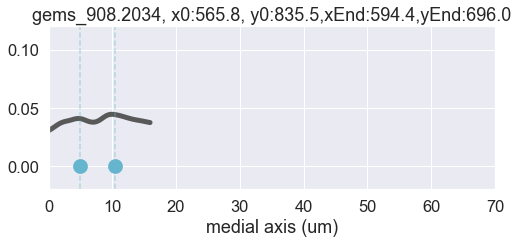

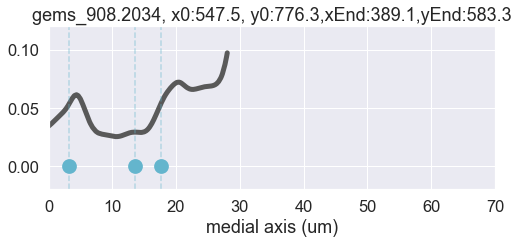

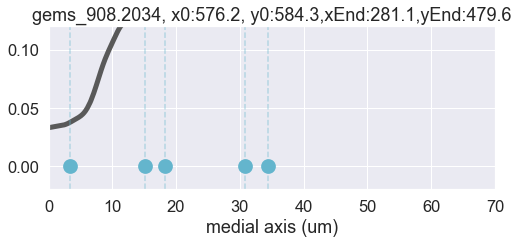

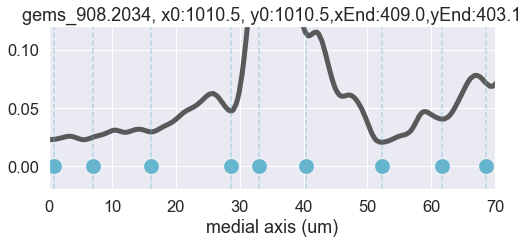

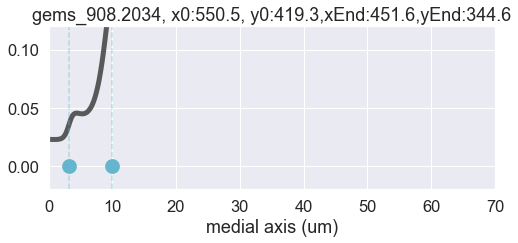

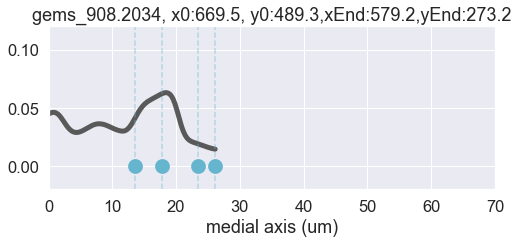

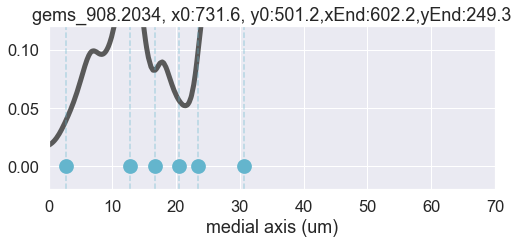

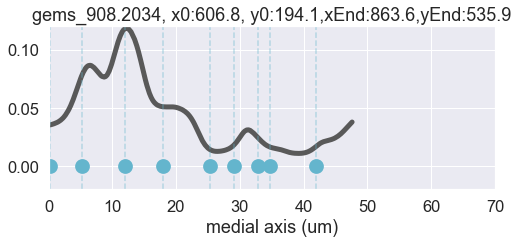

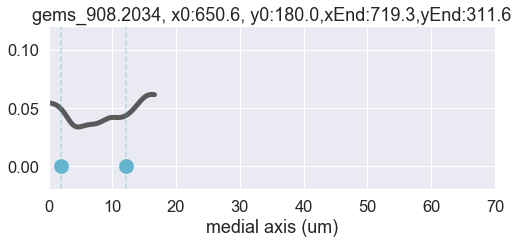

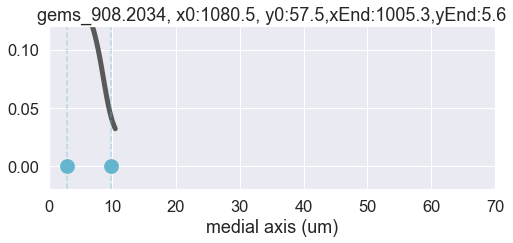

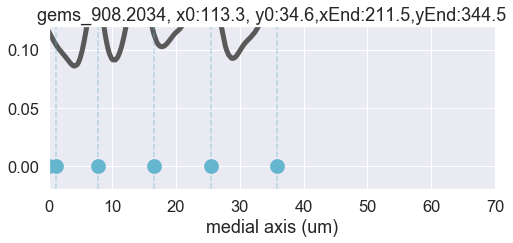

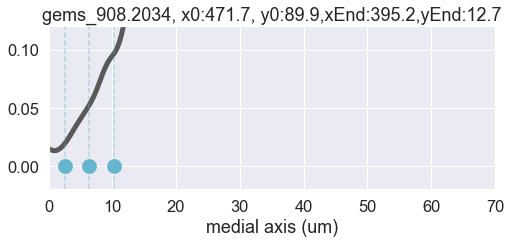

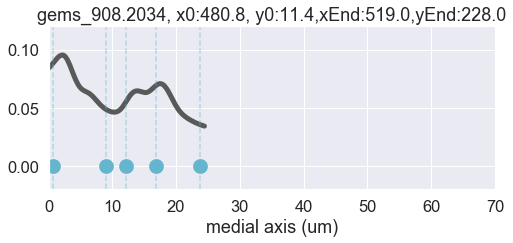

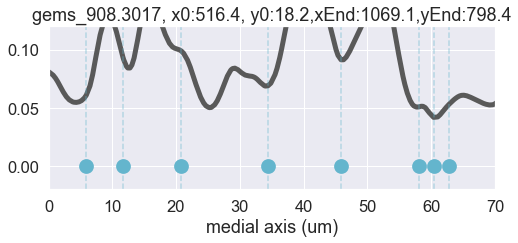

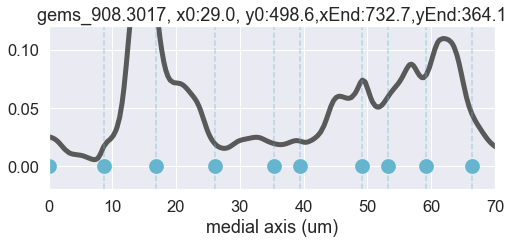

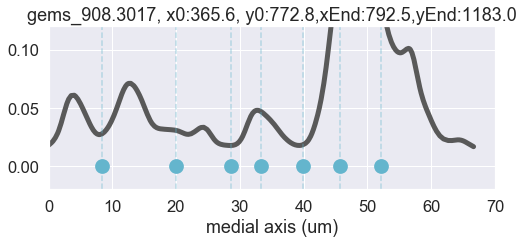

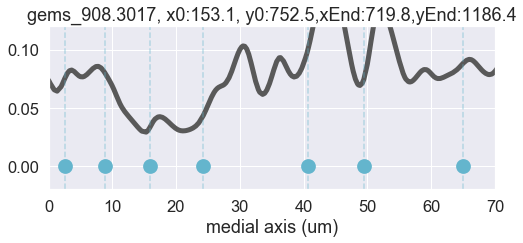

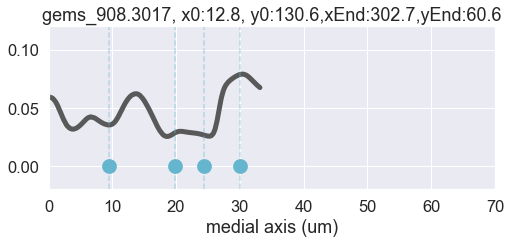

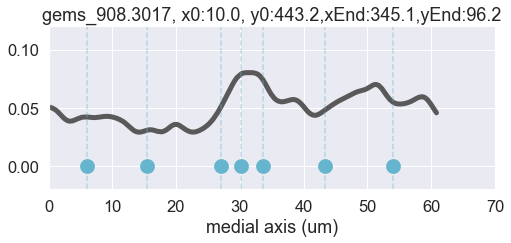

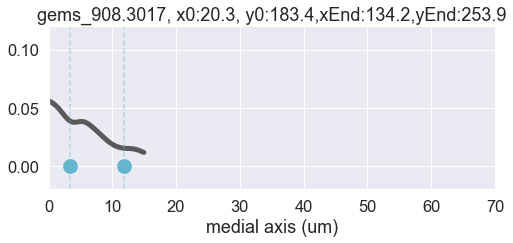

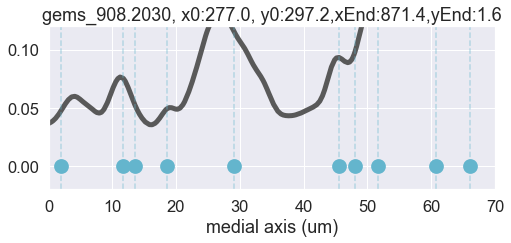

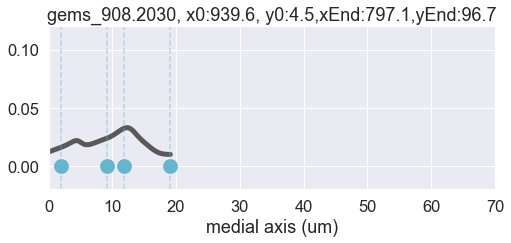

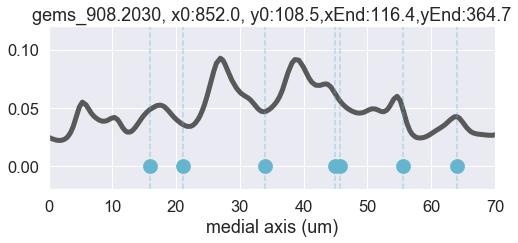

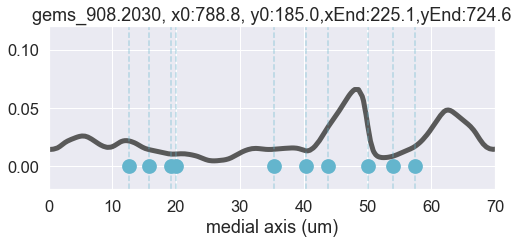

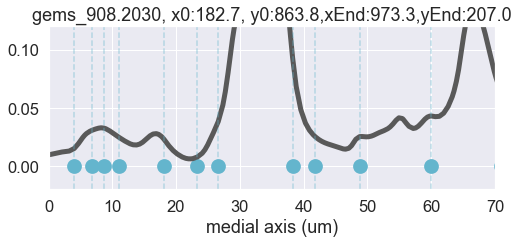

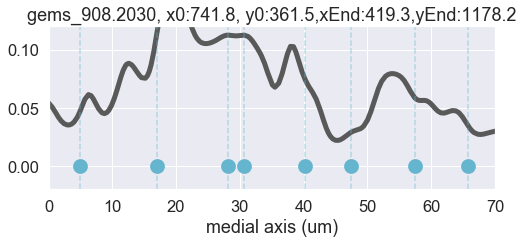

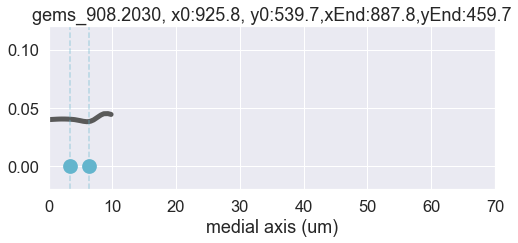

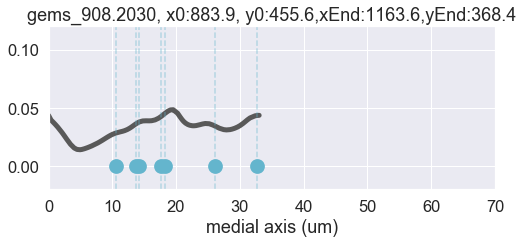

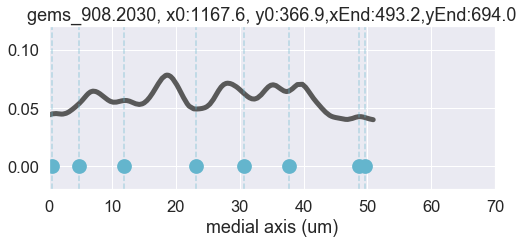

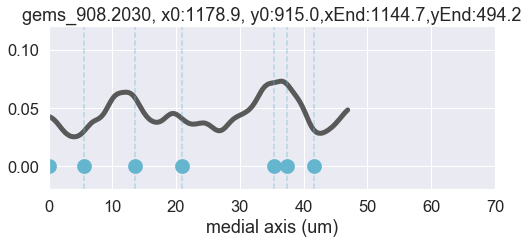

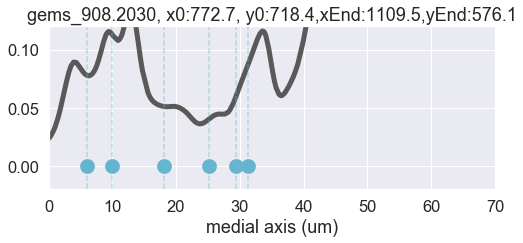

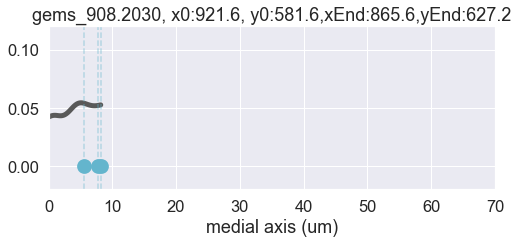

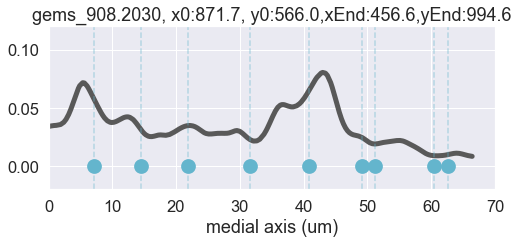

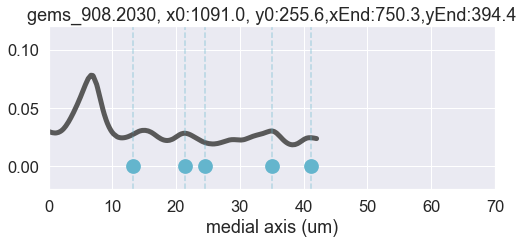

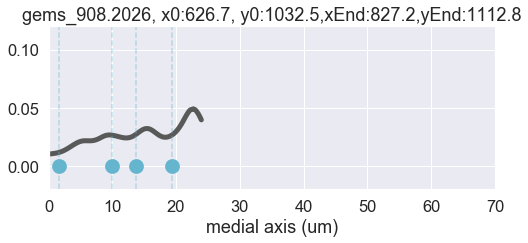

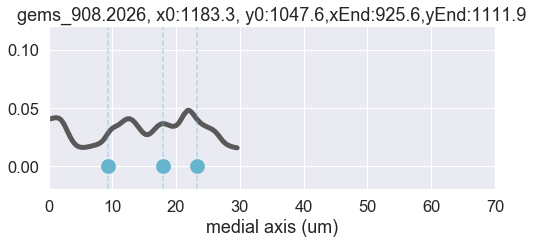

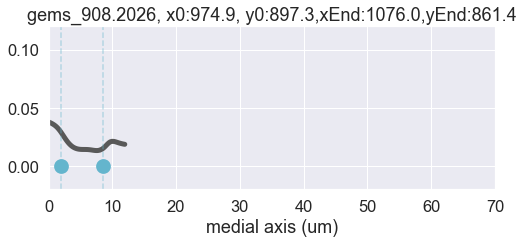

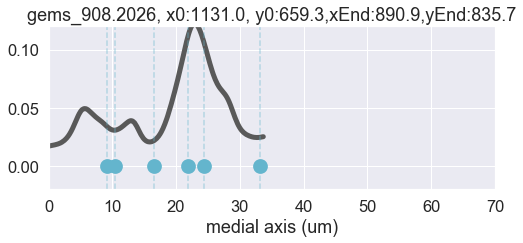

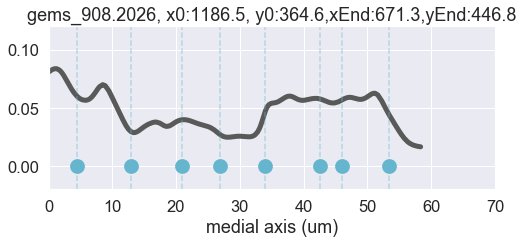

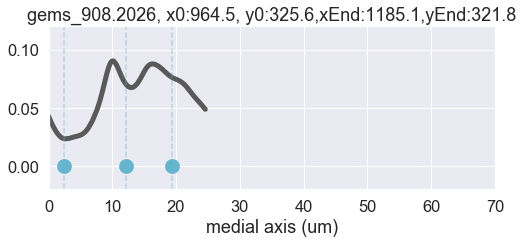

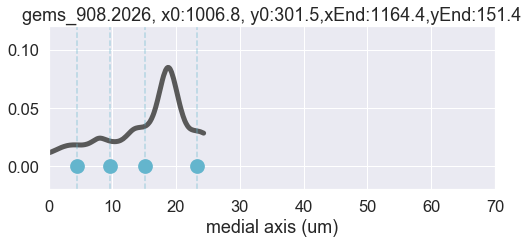

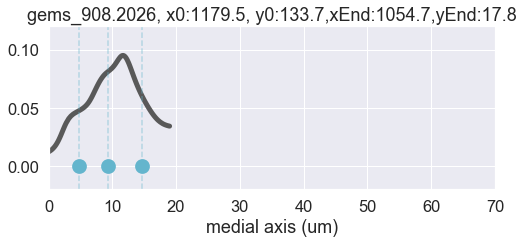

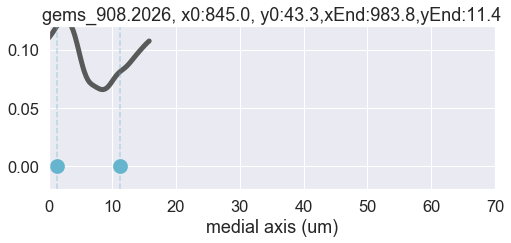

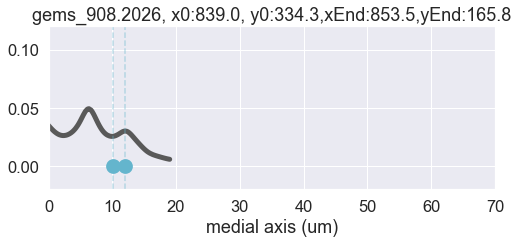

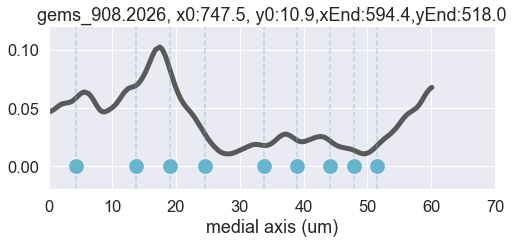

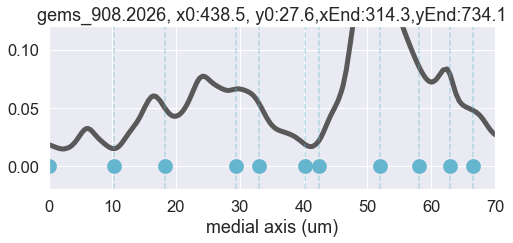

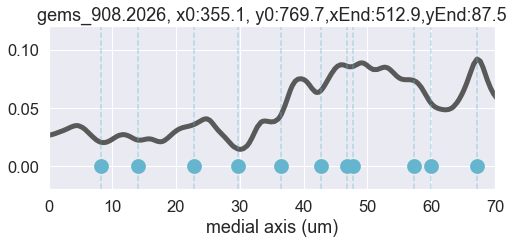

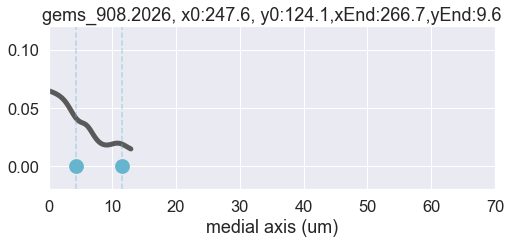

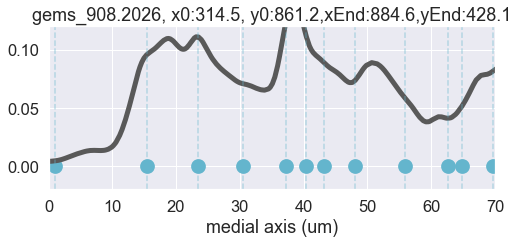

In [46]:
cell_cycle = 4 #0=G1, 1=S/G2, 2=M, 3=Unknown, 4=All
##########################################
d_set = 'GEMS-grace_dropletsAndNuclei'
##########################################
dx = 0.11029266566038132
frame = 50
dist = 2
##########################################
dt_dict = {'gems_908.2034': 0.8646714091300964, 'gems_908.2026': 1.5261081457138062, 
          'gems_908.2030': 0.8987785577774048, 'gems_908.3017': 0.861128568649292}
nest = np.load('axialData-{0}.npy'.format(d_set),allow_pickle=True,
               encoding='latin1')[0] #b/c file was made w/ python 2
vids = nest.keys()
sorted(vids)
##########################################
all_diffs = []
nuc_diffs = []
all_weights = []
nuc_weights = []
ratio_all_to_all = []
ratio_nuc_to_all = []
all_lengths = []
counter = 0
for v in vids:
    for hy in arange(len(nest[v]['diffusivity'])): 
        #removing hyphae: with problems, too short, no nuclei marked
        if v == 'gems_908.2034':
            if hy == 15 or hy == 16 or hy == 17: #too far out of the plane
                continue
        if len(nest[v]['arcLength'][hy]) < 20: 
            continue
        if len(shape(nest[v]['nucleiMedialAxisPosition'][hy])) <= 1: 
            continue                         
        ###############
        diffs_load = nest[v]['diffusivity'][hy][frame,:]*(dx**2/dt_dict[v]) 
        diffs = array([i for i in diffs_load if i!=0])                                                          
        if len(diffs) == 0:  
            continue            
        ###############
        AL = abs(nest[v]['arcLength'][hy])*dx 
        ###############
        if cell_cycle != 4:
            idx_temp = nest[v]['nucleiMedialAxisPosition'][hy]
            nuc_idx = [k for k in idx_temp[0] if #nuclei at selected cell cycle stage
                    idx_temp[1][idx_temp[0].tolist().index(k)]==cell_cycle]
        if cell_cycle == 4:
            nuc_idx = nest[v]['nucleiMedialAxisPosition'][hy][0] 
        nuc_idx_all = nest[v]['nucleiMedialAxisPosition'][hy][0] #all nuclei
        ###############
        nuc_loc_all = AL[nuc_idx_all] #AL location of all nuclei
        ############### 
        #Distance of closest nuclei to each medial axis point:
        all_dist_to_nuc = np.full(len(AL), np.inf) 
        for n in arange(len(AL)): 
            temp = nuc_loc_all - AL[n] 
            if len(temp) > 0:
                all_dist_to_nuc[n] = np.min(abs(temp))
        ###############
        #diffusivity values > dist from a nuclei:
        all_diffs = append(all_diffs, diffs[all_dist_to_nuc >= dist])
        #diffusivity values at nuclei (that are at cell_cycle):
        nuc_diffs = append(nuc_diffs, diffs[nuc_idx])
        ###############          
        diff_AL = np.diff(AL)
        weights = np.zeros(len(AL))
        weights[0] = diff_AL[0]
        weights[-1] = diff_AL[-1]
        for i, val in enumerate(weights[1:-1],1):
            weights[i] = (diff_AL[i-1] + diff_AL[i])/2
        all_weights = append(all_weights, weights[all_dist_to_nuc >= dist])
        nuc_weights = append(nuc_weights, weights[nuc_idx])
        ###############  
        for i,val in enumerate(diffs[nuc_idx]):
            ratio_nuc_to_all = append(ratio_nuc_to_all, val/
                                   np.average(diffs[all_dist_to_nuc >= dist],
                                              weights=weights[all_dist_to_nuc >= dist]))
        for i,val in enumerate(diffs[all_dist_to_nuc >= dist]):
            ratio_all_to_all = append(ratio_all_to_all, val/
                                   np.average(diffs[all_dist_to_nuc >= dist],
                                              weights=weights[all_dist_to_nuc >= dist]))
        temp = np.insert(diff_AL, 0, 0)
        temp2 = np.sum(temp[all_dist_to_nuc >= dist])
        all_lengths = append(all_lengths, temp2)
        ############## for matching to datatank:
        x0 = truncate(nest[v]['axisPosition'][hy][0][0],1)
        xEnd = truncate(nest[v]['axisPosition'][hy][0][-1],1)
        y0 = truncate(nest[v]['axisPosition'][hy][1][0],1)
        yEnd = truncate(nest[v]['axisPosition'][hy][1][-1],1)
        ##############
        #Figure 5A:
        sns.set(font_scale=1.5)
        plt.figure(figsize=(8,3))
        xlabel('medial axis (um)')
        ylim([-0.02,0.12])
        xlim([0,70])
        title('{0}, x0:{1}, y0:{2},xEnd:{3},yEnd:{4}'
              .format(v,x0,y0,xEnd,yEnd)) #for matching to datatank
        plot(AL, diffs, linewidth=5,color=[0.35,0.35,0.35]) #medial axis plots     
        scatter(nuc_loc_all, zeros(len(nuc_loc_all)), linewidth=2.5,s=150,c='c')
        for xc in nuc_loc_all:
            plt.axvline(x = xc, color='c', linestyle='--',alpha=0.4)
        #####
        counter += 1
#         plt.savefig('nucleiLocs-{0}.pdf'.format(counter))

0.06283659454828275
4457
353
0.06045352285986491


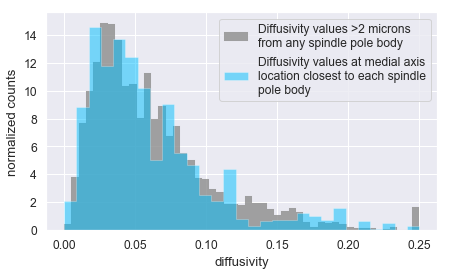

In [47]:
#figure 5B
fig = plt.figure(1,figsize=(7,4))
sns.set(font_scale=1.1)
######
plt.hist(np.clip(all_diffs,0,0.25), color=[0.55,0.55,0.55], bins=linspace(0,0.25,50),lw=0.4,
         alpha=.8, weights=all_weights, density=True, histtype='stepfilled', linewidth=0.05,
         edgecolor=[0.55,0.55,0.55],
         label='Diffusivity values >2 microns\nfrom any spindle pole body')
plt.hist(np.clip(nuc_diffs,0,0.25),color='deepskyblue',bins=linspace(0,0.25,30),lw=0.4,
         alpha=0.5, weights=nuc_weights, density=True, histtype='stepfilled', linewidth=0.5,
         label='Diffusivity values at medial axis\nlocation closest to each spindle\npole body',
         edgecolor='w')
######
plt.legend()
xlabel('diffusivity')
ylabel('normalized counts')
title('')
# fig.savefig('allDiffsAndNuc.pdf')
print(mean(all_diffs))
print(len(all_diffs))
print(len(nuc_diffs))
print(mean(nuc_diffs))

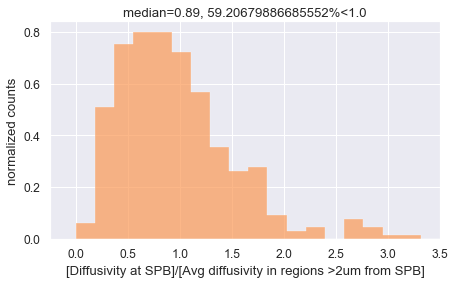

In [51]:
#figure 5C
fig = plt.figure(1,figsize=(7,4))
plt.hist(ratio_nuc_to_all, color=[0.984, 0.6, 0.337], lw=0.4, alpha=0.7, 
        bins=linspace(0,3.5,20), histtype='stepfilled',
        density=True,label='Ratio of Diffusivity at tips')
ylabel('normalized counts')
xlabel('[Diffusivity at SPB]/[Avg diffusivity in regions >2um from SPB]')
per_less_1 = 100*len(ratio_nuc_to_all[ratio_nuc_to_all<1])/len(ratio_nuc_to_all)
title('median={0}, {1}%<1.0'.format(round(np.median(ratio_nuc_to_all),2),per_less_1))
xlim(-0.25,3.5);
# fig.savefig('ratioNuc.pdf')

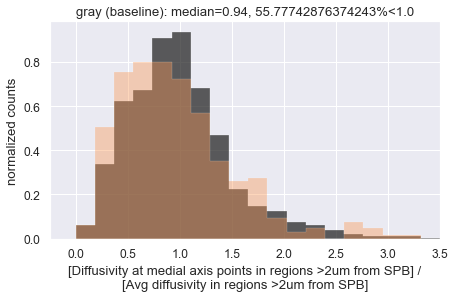

In [50]:
#Stats for table 2, for cell cycle stage defined above
n = 3
all_p = []
for k in np.arange(1000):  
    temp = np.random.choice(ratio_all_to_all, size=int(np.sum(all_lengths)/n) ,replace=True)
    D, p = scipy.stats.ks_2samp(temp, ratio_nuc_to_all)
    all_p = append(all_p, p)
avg_p = np.mean(all_p)

fig = plt.figure(1,figsize=(7,4))
plt.hist(ratio_all_to_all,color='k',lw=0.4,alpha=0.7,bins=linspace(0,3.5,20),
        histtype='stepfilled',density=True,label='Ratio of Diffusivity at tips')
plt.hist(ratio_nuc_to_all,color=[0.984, 0.6, 0.337],lw=0.4,alpha=0.4,bins=linspace(0,3.5,20),
        histtype='stepfilled',density=True,label='Ratio of Diffusivity at tips')
ylabel('normalized counts')
xlabel('[Diffusivity at medial axis points in regions >2um from SPB] /\n[Avg diffusivity in regions >2um from SPB]')
perLess1 = 100*len(ratio_all_to_all[ratio_all_to_all<1])/len(ratio_all_to_all)
title('gray (baseline): median={0}, {1}%<1.0'.format(round(np.median(ratio_all_to_all),2),perLess1))
xlim(-0.25,3.5);